## Projet Deep Learning : Reconnaissance d'images de pays
## **Modelisation**

#### Dataset: 
Google Landmarks Dataset v2 :
https://github.com/cvdfoundation/google-landmark?tab=readme-ov-file


#### Objectif du projet :
<p style="text-align: justify;">
    L'objectif de ce projet est de développer une solution de Deep Learning pour la reconnaissance d'images. L'input sera une image d'un lieu, et la sortie du modèle sera le pays correspondant, accompagnée de probabilités d'appartenance.
</p>


In [18]:
# Packages
from datetime import datetime
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from tqdm import tqdm

In [ ]:
# Variables globales
DATA_TRAIN_PATH = "data/train"
DATA_RESULTS = "data/results"
MODELS = "models"

### Importation des datasets

Importation d'un subset

In [ ]:
train_dataset = torch.load(f"{DATA_TRAIN_PATH}/train_subset.pt", weights_only=False)

Import du labels mapping (etiquette pour chaque pays)

In [21]:
with open(f"{DATA_RESULTS}/country_labels.json", "r") as f:
    label_mapping = json.load(f)

Train val test split

In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = int(0.2 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size])

# data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Récupération des labels du train

In [23]:
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy())

In [24]:
# Variables de config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = max(all_labels) + 1
NUM_EPOCHS = 1
LEARNING_RATE = 0.001

Modèle RESNET50

In [25]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(ResNet50Model, self).__init__() # heritge de ResNet50Model
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) # ResNet50 pre trained
        # remplacement de la derniere couche pour classes de pays
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        """
        la façon dont les données passent à travers le modèle
        """
        batch_size, seq_len, channels, height, width = x.shape
        x = x.squeeze(1)  # pour passer de [batch_size, 1, 3, 224, 224] à [batch_size, 3, 224, 224]
        return self.resnet(x)

Initialisation du modèle, de la fonction de perte et de l'optimiseur

In [26]:
model = ResNet50Model(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Fonctions train, evaluate

In [27]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train() # mode train
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ajout des stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval() # mode evaluation
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Entrainement


100%|██████████| 16/16 [02:55<00:00, 10.99s/it]


Epoch [1/1]
Train Loss: 3.9664, Train Acc: 0.0960
Val Loss: 59.4452, Val Acc: 0.0200


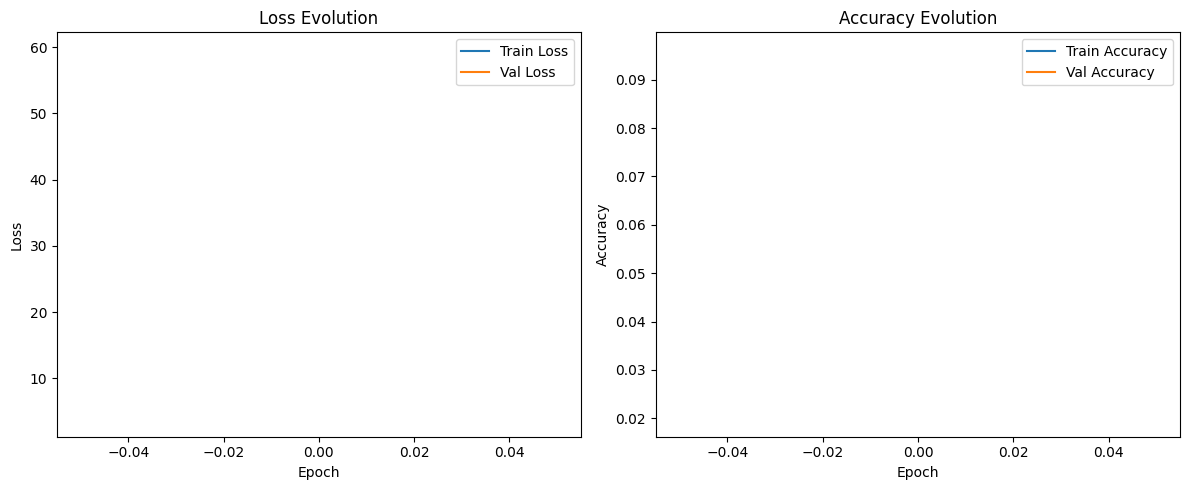

In [28]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    # training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # validation
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


# graphique de l'évolution de la loss pendant le training
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

Sauvegarde du modèle

In [29]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model.state_dict(), f"{MODELS}/resnet50_model_{time}.pth")

In [30]:
# import du modele entrainé
# model = ResNet50Model(num_classes=NUM_CLASSES).to(DEVICE)
# model.load_state_dict(torch.load("resnet50_model.pth"))

Evaluation des performances le dataset Test

In [31]:
test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

all_predictions = []
all_true_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# rapport de classification
class_report_txt = classification_report(all_true_labels, all_predictions, output_dict=False)
class_report_dict = classification_report(all_true_labels, all_predictions, output_dict=True)
print(class_report_txt)

Test Loss: 74.6634, Test Accuracy: 0.0280
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          19       0.00      0.00      0.00        10
          20       0.00      0.00      

c:\Users\lebre\OneDrive\Bureau\Deep Learning\projet_dl\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lebre\OneDrive\Bureau\Deep Learning\projet_dl\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lebre\OneDrive\Bureau\Deep Learning\projet_dl\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [32]:
df_report = pd.DataFrame(class_report_dict).T
df_report["country"] = df_report.index
df_report["country"] = df_report["country"].map(label_mapping)
df_report

,precision,recall,f1-score,support,country
0,0.000000,0.000000,0.000000,2.000,Argentina
1,0.000000,0.000000,0.000000,2.000,Armenia
2,0.000000,0.000000,0.000000,3.000,Australia
3,0.000000,0.000000,0.000000,6.000,Austria
5,0.000000,0.000000,0.000000,1.000,Belarus
6,0.000000,0.000000,0.000000,3.000,Belgium
8,0.000000,0.000000,0.000000,2.000,Bosnia and Herzegovina
9,0.000000,0.000000,0.000000,2.000,Brazil
11,0.000000,0.000000,0.000000,1.000,Cambodia
12,0.000000,0.000000,0.000000,1.000,Cameroon
